# Analysing Onsala-1 radio spectra obtained from OSO 20m telescope

In this notebook, we will analyse a spectrum of Onsala-1 molecular cloud obtained from 20m telescope at OSO. The spectra were measured in radio frequencies and have four emission lines of $CH_3CCH$. The main goal is to find the area under the lines, which is basically the integrated antenna temperature under these lines. With this we can compute the column density of the $CH_3CCH$.

The focus of this notebook is Onsala-1. Once we have worked it out, we can make a routine to compute the same for the rest of the targets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import emcee
import os
from glob import glob
import astropy.constants as con
import utils as utl
from scipy.optimize import minimize

We first make a list of all fits file which has spectrum of Onsala-1. We also list the system temperature and the total integration time, which we need to compute the combined/average spectrum (to gain a higher S/N).

In [2]:
# Listing all of the fits file
f1 = glob(os.getcwd() + '/Data/*.fits')
ons, tsys, int_time = np.array([]), np.array([]), np.array([])
print('File\t\tObject\t\tT_sys\tINTTIME')
print('-----------------------------------------------')
for i in range(len(f1)):
    hdul = fits.open(f1[i])
    hdr = hdul[0].header
    if hdr['OBJECT'] == 'Onsala 1':
        ons = np.hstack((ons, f1[i]))
        tsys, int_time = np.hstack((tsys, hdr['TSYS'])),\
             np.hstack((int_time, hdr['INTTIME']))
        print(f1[i].split('/')[-1] + '\t' + hdr['OBJECT'] + '\t'\
             + str(hdr['TSYS']) + '\t' + str(hdr['INTTIME']))

File		Object		T_sys	INTTIME
-----------------------------------------------
2136049a.fits	Onsala 1	222.9	202.402
2136054a.fits	Onsala 1	210.84	203.066
2136035a.fits	Onsala 1	234.93	203.169
2136032a.fits	Onsala 1	234.93	202.38
2136068a.fits	Onsala 1	210.54	203.964
2136071a.fits	Onsala 1	210.54	202.298
2136057a.fits	Onsala 1	210.84	203.958
2136038a.fits	Onsala 1	234.93	202.369
2136021a.fits	Onsala 1	262.31	202.416
2136060a.fits	Onsala 1	210.84	202.228
2136046a.fits	Onsala 1	222.9	204.005
2136027a.fits	Onsala 1	262.31	202.399
2136065a.fits	Onsala 1	210.54	203.191
2136043a.fits	Onsala 1	222.9	203.941
2136024a.fits	Onsala 1	262.31	202.373


We can now compute an average spectrum out of all of these spectra!

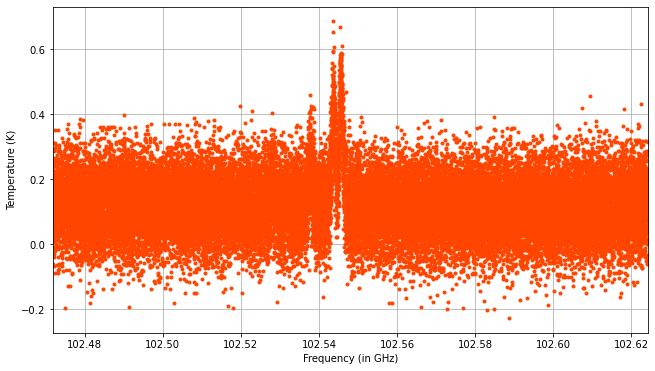

In [3]:
# For zeroth spectra
hdul5 = fits.open(ons[0])
hdr5, dta5 = hdul5[0].header, hdul5[0].data[0][0]
ii5 = np.arange(hdr5['NAXIS1']) + 1
freq_all = hdr5['RESTFREQ'] + hdr5['CRVAL1'] + hdr5['CDELT1']*(ii5-hdr5['CRPIX1'])
freq_all = int_time[0]*freq_all/tsys[0]
temp_all = int_time[0]*dta5/tsys[0]
# For all other spectra
for i in range(len(ons)-1):
    hdul5 = fits.open(ons[i+1])
    hdr5, dta5 = hdul5[0].header, hdul5[0].data[0][0]
    ii5 = np.arange(hdr5['NAXIS1']) + 1
    frq5 = hdr5['RESTFREQ'] + hdr5['CRVAL1'] + hdr5['CDELT1']*(ii5-hdr5['CRPIX1'])
    # Saving the data
    temp_all = np.vstack((temp_all, int_time[i+1]*dta5/tsys[i+1]))
    freq_all = np.vstack((freq_all, int_time[i+1]*frq5/tsys[i+1]))
# Weighted average (weighted with int_time/Tsys) over all the spectra
freq_avg = np.sum(freq_all, axis=0)/np.sum(int_time/tsys)
temp_avg = np.sum(temp_all, axis=0)/np.sum(int_time/tsys)

# Plotting the result:
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(freq_avg/1e9, temp_avg, fmt='.', c='orangered')
plt.xlabel('Frequency (in GHz)')
plt.ylabel('Temperature (K)')
plt.xlim([np.min(freq_avg/1e9), np.max(freq_avg/1e9)])
plt.grid()

There we go! This is a nice spectrum of Onsala 1!
We can first convert frequency to the velocity first -- to do this we can use the following Doppler formula:

$$v = c \cdot \frac{f_s - f_o}{f_s}$$

The symbols have their usual meanings. We know the rest and observed frequency of the reference channel -- we also know the observed frequencies of each channel, but not the rest frequency. We can find the rest frequencies of each channel by just taking the difference b/w the observed frequencies of the given channel and the reference channel, and then apply this difference to the rest frequencies!

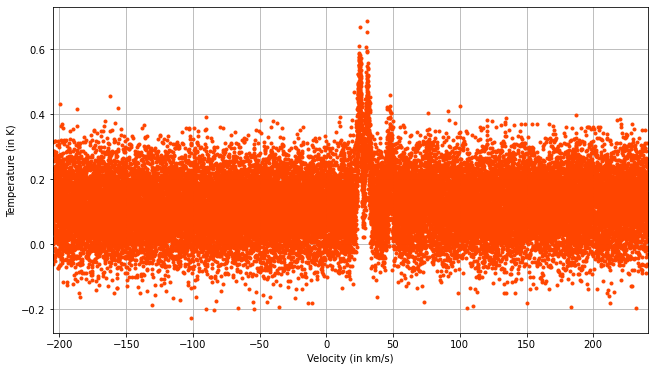

In [4]:
# To find the rest frame frequency
diff = freq_avg - hdr5['OBSFREQ']
rest_freq = hdr5['OBSFREQ']#freq_avg + diff
# To find the velocity of the target!
velo_avg = con.c.value*(rest_freq - freq_avg)/rest_freq
velo_avg = velo_avg + hdr5['VLSR'] + hdr5['VELO-GEO'] + hdr5['VELO-HEL']
# We can plot the results
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(velo_avg/1e3, temp_avg, fmt='.', c='orangered')
plt.xlabel('Velocity (in km/s)')
plt.ylabel('Temperature (in K)')
plt.xlim([np.min(velo_avg/1e3), np.max(velo_avg/1e3)])
plt.grid()

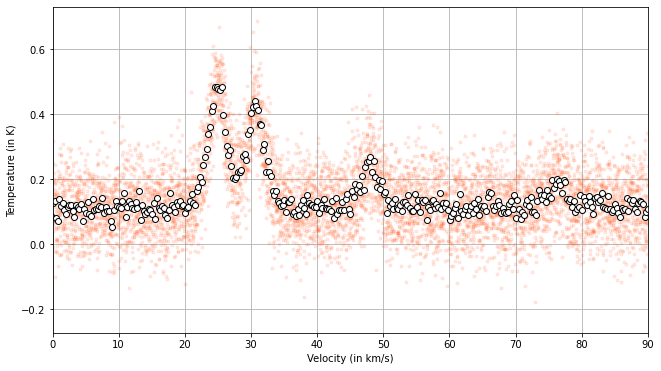

In [5]:
# We can plot the results
## Binned data
velo_bin, temp_bin, _, _ = utl.lcbin(velo_avg, temp_avg, binwidth=250)
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(velo_avg/1e3, temp_avg, fmt='.', c='orangered', alpha=0.1)
plt.errorbar(velo_bin/1e3, temp_bin, fmt='o', mfc='white', c='black')
plt.xlabel('Velocity (in km/s)')
plt.ylabel('Temperature (in K)')
plt.xlim([0, 90])
plt.grid()

So, there are four lines (though we cannot see them individually) along with some offset trend. What we can do is to build a model that has four gaussian models and a linear model. Then we can use `emcee` to fit the model.

In [7]:
def model(x, m, c, am1, am2, am3, am4, mu1, mu2, mu3, mu4, si1, si2, si3, si4):
    ln1 = utl.line(x, m, c)
    gau1 = utl.gaus(x, am1, mu1, si1)
    gau2 = utl.gaus(x, am2, mu2, si2)
    gau3 = utl.gaus(x, am3, mu3, si3)
    gau4 = utl.gaus(x, am4, mu4, si4)
    return ln1 + gau1 + gau2 + gau3 + gau4

def lnlike(x):
    global velo_avg, temp_avg
    m, c, am1, am2, am3, am4, mu1, mu2, mu3, mu4, si1, si2, si3, si4 = x
    mod = model(velo_avg, m, c, am1, am2, am3, am4, mu1, mu2, mu3, mu4, si1, si2, si3, si4)
    chi2 = (temp_avg - mod)**2
    return np.sum(chi2)

We can now use `scipy.optimize.minimize` to find the "first" best-fitted parameters.

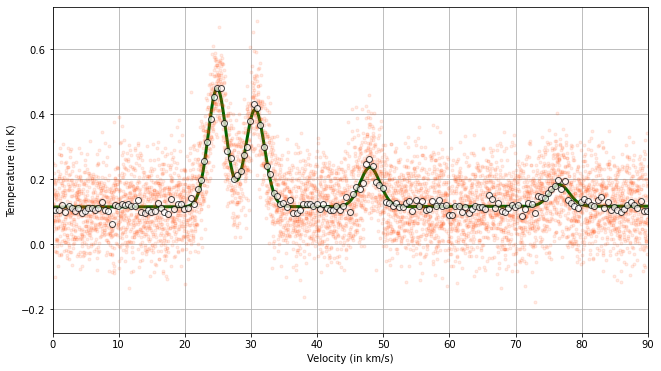

In [16]:
xinit = np.array([0., 0.1, 0.4, 0.3, 0.13, 0.1,\
     25000, 30000, 47000, 77000, 1.5*1000, 1.5*1000, 1.5*1000, 1.5*1000])
soln = minimize(lnlike, x0=xinit, method='BFGS')

vall = np.linspace(np.min(velo_avg), np.max(velo_avg), 10000)
best_fit = model(vall, *soln.x)

velo_bin, temp_bin, _, _ = utl.lcbin(velo_avg, temp_avg, binwidth=500)
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(velo_avg/1e3, temp_avg, fmt='.', c='orangered', alpha=0.1)
plt.errorbar(velo_bin/1e3, temp_bin, fmt='o', mfc='white', c='black', alpha=0.7)
plt.plot(vall/1e3, best_fit, c='darkgreen', lw=3)
plt.xlabel('Velocity (in km/s)')
plt.ylabel('Temperature (in K)')
plt.xlim([0, 90])
plt.grid()